# ALERT Doctoral School 2023
## Hands-on Policy Gradient algorithm for the Miner game
### Authors: Alexandros Stathas, Diego Gutierrez-Oribio, Ioannis Stefanou

In this code, you can train a Policy Gradient algorithm to solve the Miner game on a 4x4 grid.

#### Main Libraries

In [1]:
from Miner_v1 import Miner, generate_random_map
from plotter import plot_env, plot_arrows 
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

2023-09-18 15:05:29.176241: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 15:05:29.177525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:05:29.205236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:05:29.206030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 15:05:29.664528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Initialization of the Miner environment

In [3]:
env = Miner(desc=["FFFG", "FFFF", "FFFF", "HSFF"], is_slippery=False, render_mode="ansi")
env.reset()

state_size = env.observation_space.n
action_size = env.action_space.n

#### Neural network

In [4]:
class PolicyNetwork(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc3 = Dense(action_size, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        return self.fc3(x)

#### Single step in the environment

In [5]:
def play_one_step(env,obs,model,loss_fn):
    with tf.GradientTape() as tape:

        states_array= np.zeros((1,state_size))
        states_array[0,obs]=1
        
        prob = model(states_array)
        
        prob1 = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob1, dtype=tf.float32)
        action = dist.sample()
        loss = tf.reduce_mean(loss_fn(action,prob))
    grads = tape.gradient(loss,model.trainable_variables)

    selected_action = int(action.numpy()[0])
    obs, reward, done, info = env.step(selected_action)[:4]
    return obs, reward, done, grads, selected_action

#### Multiple steps in the environment

In [6]:
def play_multiple_episodes(env,n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    Total_episode_reward = []
    Total_batch_reward = []
    all_actions = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        current_action = []
        obs, _ = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads, action = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            current_action.append(action)
            if done:
                break
                
        Total_episode_reward = np.sum(current_rewards)
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        all_actions.append(current_action)
    Total_batch_reward.append(Total_episode_reward)
    return all_rewards, all_grads, Total_batch_reward, all_actions

#### Functions to get the reward

In [7]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2,-1,-1):
        discounted[step]+=discounted[step+1]*discount_factor
    return discounted

In [8]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards-reward_mean)/reward_std 
            for discounted_rewards in all_discounted_rewards]

#### Training hyperparameters 

In [9]:
n_iterations=100
n_episodes_per_update = 10
n_max_steps = 20
discount_factor = 0.99
lr = 0.01

#### Policy Gradient algorithm

In [14]:
tf.keras.backend.clear_session()
model = PolicyNetwork(state_size, action_size)
optimizer = optimizers.Adam(learning_rate=lr)
loss_fn = losses.SparseCategoricalCrossentropy()

Rewards = []
for iteration in range(n_iterations):
    all_rewards, all_grads, Total_reward, all_actions = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
 
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor)
    all_mean_grads = []

    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward*all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)],axis=0)
        all_mean_grads.append(mean_grads)
        
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    Rewards.append(Total_reward)
    print('Iteration =',iteration+1,'/',n_iterations)

Iteration= 1 / 100
Iteration= 2 / 100
Iteration= 3 / 100
Iteration= 4 / 100
Iteration= 5 / 100
Iteration= 6 / 100
Iteration= 7 / 100
Iteration= 8 / 100
Iteration= 9 / 100
Iteration= 10 / 100
Iteration= 11 / 100
Iteration= 12 / 100
Iteration= 13 / 100
Iteration= 14 / 100
Iteration= 15 / 100
Iteration= 16 / 100
Iteration= 17 / 100
Iteration= 18 / 100
Iteration= 19 / 100
Iteration= 20 / 100
Iteration= 21 / 100
Iteration= 22 / 100
Iteration= 23 / 100
Iteration= 24 / 100
Iteration= 25 / 100
Iteration= 26 / 100
Iteration= 27 / 100
Iteration= 28 / 100
Iteration= 29 / 100
Iteration= 30 / 100
Iteration= 31 / 100
Iteration= 32 / 100
Iteration= 33 / 100
Iteration= 34 / 100
Iteration= 35 / 100
Iteration= 36 / 100
Iteration= 37 / 100
Iteration= 38 / 100
Iteration= 39 / 100
Iteration= 40 / 100
Iteration= 41 / 100
Iteration= 42 / 100
Iteration= 43 / 100
Iteration= 44 / 100
Iteration= 45 / 100
Iteration= 46 / 100
Iteration= 47 / 100
Iteration= 48 / 100
Iteration= 49 / 100
Iteration= 50 / 100
Iteration

#### Results

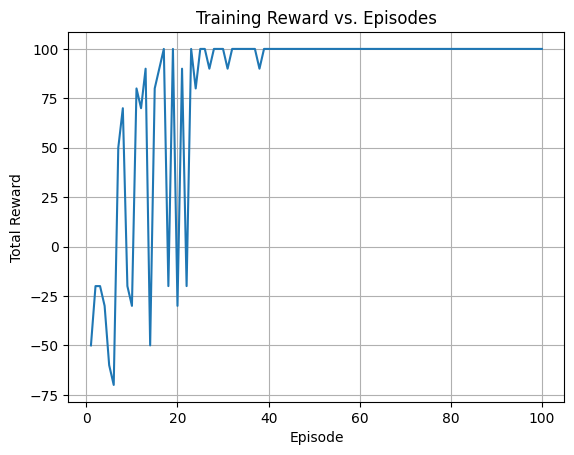

In [15]:
plt.plot(range(1, n_iterations + 1), Rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward vs. Episodes')
plt.grid(True)
plt.show()

In [16]:
#Obtain optimal policy
probs=[]
actions=[]
for state in range(0,state_size):
    states_array= np.zeros((1,state_size))
    states_array[0,state]=1

    prob = model.predict(states_array)

    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    action = dist.sample()
    probs.append(prob)
    actions.append(action)
probs=np.array(probs) 
actions=np.array(actions)

1/1 [==============================] - 0s 18ms/step


Optimal Policy:



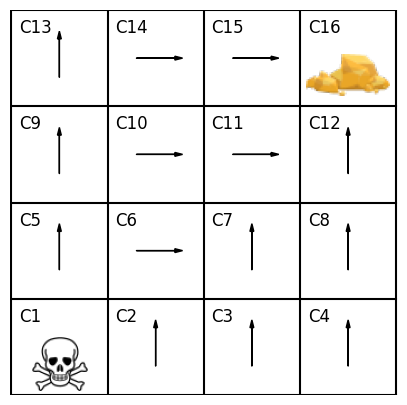

In [17]:
print("Optimal Policy:\n")
game_actions_to_plotter_arrows = {'0': 2,'1': 1, '3':3, '2':4}
policy = np.array(actions.flatten()).astype(int).astype(str)
policy_arrow_compatible =np.array([game_actions_to_plotter_arrows[key] for key in policy],dtype=np.int32)
policy_arrow_compatible=policy_arrow_compatible.reshape((-1,4))[::-1,:].reshape((16))
M=4;Lx=5;Ly=5
fig, ax = plt.subplots()
plot_env(fig,ax,M,Lx,Ly)
plot_arrows(fig,ax,policy_arrow_compatible,M,Lx,Ly)
plt.show()

#### Testing of your policy in the Miner game

In [18]:
Actions = np.array(all_actions)[n_episodes_per_update-1,:]

# Create the Miner environment with custom map and no slipperiness
env_test = Miner(desc=["FFFG", "FFFF", "FFFF", "HSFF"], is_slippery=False, render_mode="human")
env_test.reset()

# Lists to store states, actions, rewards, and dones during the play
states, actions, rewards, dones = [], [], [], []

def show_state(obs):
    # Render the environment using matplotlib
    env_test.render()
    # Pause for a short time to allow the plot to update
    plt.pause(0.01)

for index in range(len(Actions)):
    
    obs_tp1, rew, done, _ = env_test.step(Actions[index])[:4] 

    # Append the states, actions, rewards, and dones to the lists
    states.append(obs_tp1)
    rewards.append(rew)
    dones.append(done)  

    # Show the updated state of the environment
    show_state(obs_tp1)

    if done == True:
        if rew > 0:
            print("Congratulations! You reached the gold!")
        else:
            print("Oops! You fell into a hole!")
            
# Print the information after the game ends
print("Total number of moves:", np.size(states))
print("Final reward:", int(sum(rewards)))
    
# Close the environment after finishing the game
env_test.close()

Congratulations! You reached the gold!
Total number of moves: 5
Final reward: 100
